## Risk Parity Investment Strategy
#### Goal is to make portfolio which consists of diverse asset classes
Use ETF data of representative asset classes  
Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included in universe  
Resuld is driven from 2010 to 2021 market data  

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [17]:
import quantstats
from scipy.optimize import minimize

In [18]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [19]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [20]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [21]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

In [22]:
class RiskParity(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)
        # return_df = return_df.fillna(1)
        # self.return_df_dd = return_df

        covariance_matrix = return_df.cov()
        target = {}        


        x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
        constraints = ({'type': 'eq', 'fun': self.SumConstraint},
                    {'type': 'ineq', 'fun': self.LongOnly})
        options = {'ftol': 1e-20, 'maxiter': 2000}

        upper_bound = 0.50
        lower_bound = 0.01        
        bounds = []
        for i in range(len(tickers)):
            bounds.append((lower_bound, upper_bound))
        bounds = tuple(bounds)

        result = minimize(fun = self.RiskParityObjective,
                        args = (covariance_matrix),
                        x0 = x0,
                        method = 'SLSQP',
                        constraints = constraints,
                        bounds=bounds,
                        options = options)

        target = {}
        for i in range(len(custom_universe)):
            target[custom_universe[i]] = result.x[i]

        return target


    def RiskParityObjective(self, x, covariance_matrix) :
        # x means weight of portfolio
        variance = (x.T) @ (covariance_matrix) @ (x)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * (covariance_matrix @ x)
        risk_contribution = x * mrc
        a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

        # set marginal risk level of asset classes equal
        risk_diffs = a - a.T
        # np.ravel: convert n-dim to 1-dim
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        return (sum_risk_diffs_squared)

    # constraint 1 : sum of weight should be less than equal to 1
    def SumConstraint(self, weight):
        return (weight.sum()-1.0)

    # constraint 2 : long only portfolio should be consists of postive weight vectors
    def LongOnly(self, weight):
        return(weight)
    
    # calculate risk contribution
    def RiskContribution(weight, covariance_matrix) :
        """
        to check whether given portfolio is equally distributed
        :param weight: asset allocation weight of portfolio
        :param covariance_matrix:
        :return: risk contribution of each asset
        """
        weight = np.array(weight)
        variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * np.dot(covariance_matrix, weight)

        risk_contribution = weight * mrc
        risk_contribution = risk_contribution / risk_contribution.sum()
        return risk_contribution

In [23]:
custom_universe = [
    'SPY', # SPDR S&P 500 ETF Trust
    'EFA', # iShares MSCI EAFE ETF
    'EEM', # iShares MSCI Emerging Markets ETF
    'TLT', # iShares 20+ Year Treasury Bond ETF
    'IEF', # iShares 7-10 Year Treasury Bond ETF
    'SHY', # iShares 1-3 Year Treasury Bond ETF
    'LQD', # iShares iBoxx Investment Grade Corporate Bond ETF
    'TIP', # iShares TIPS Bond ETF
    'VNQ', # Vanguard Real Estate Index Fund
    'GLD'  # SPDR Gold Shares
    ]


In [24]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = RiskParity(engine.cache)
engine.run_backtest(target_generator=rp, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 8.41 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.699 / time elapsed:123.1 ===
[run_backtest] is executed in 123.91 seconds


In [25]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate=start_date, edate=end_date, transaction_cost=cost)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 10.61 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.570 / time elapsed:11.1 ===
[run_backtest] is executed in 11.31 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          170.13%     157.28%
CAGR﹪                     6.24%       5.92%

Sharpe                     0.65        0.66
Prob. Sharpe Ratio         99.54%      99.62%
Smart Sharpe               0.65        0.66
Sortino                    0.92        0.95
Smart Sortino              0.92        0.94
Sortino/√2                 0.65        0.67
Smart Sortino/√2           0.65        0.67
Omega                      1.12        1.12

Max Drawdown               -21.54%     -28.05%
Longest DD Days            2448        540
Volatility (ann.)          10.16%      9.36%
R^2                        0.41        0.41
Information Ratio          0.0         0.0
Calmar                     0.29        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-03-18,2008-11-12,2009-09-10,541,-21.544954,-20.450583
2,2012-10-05,2015-12-17,2019-06-19,2448,-20.188308,-19.341884
3,2020-03-09,2020-03-19,2020-04-29,51,-12.960261,-12.507328
4,2006-05-12,2006-06-14,2006-11-30,202,-11.095199,-10.606676
5,2020-08-07,2021-03-08,2022-03-08,578,-10.135577,-9.128689


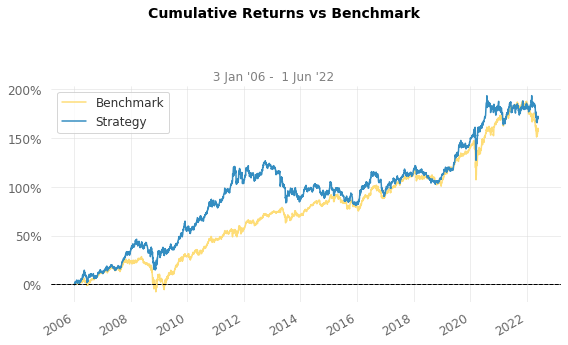

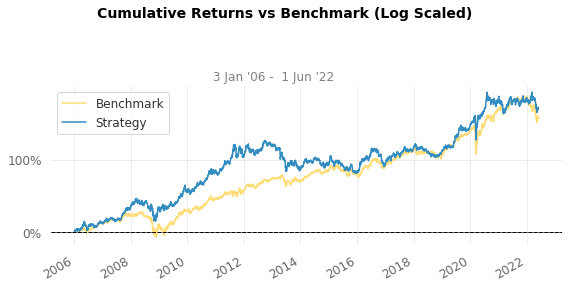

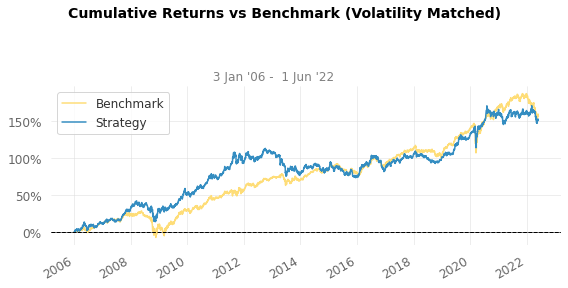

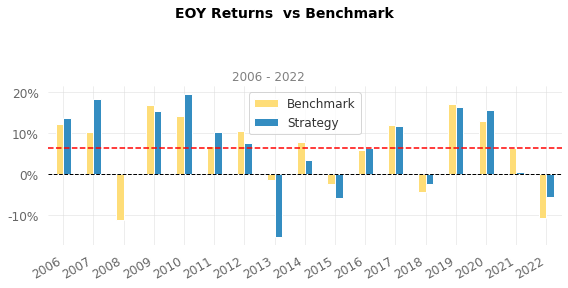

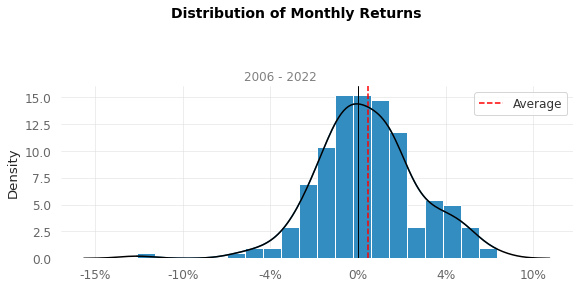

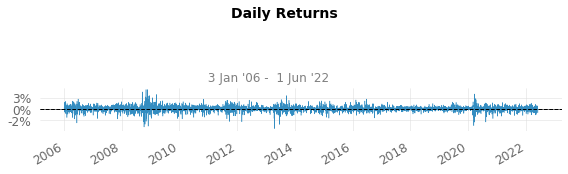

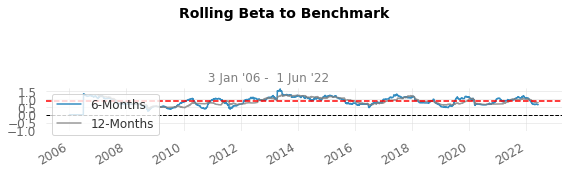

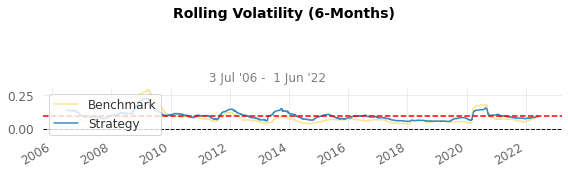

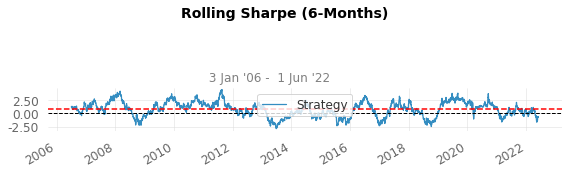

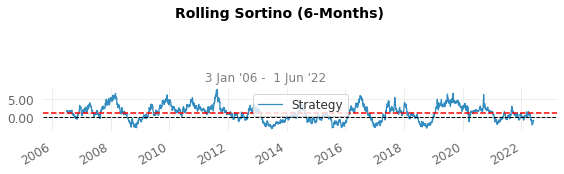

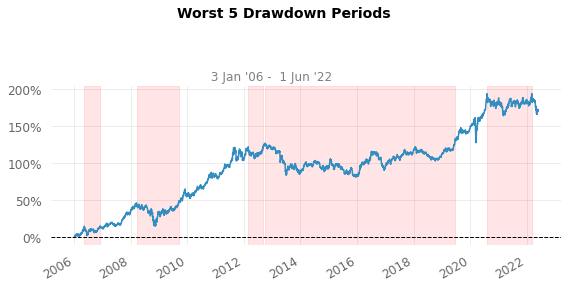

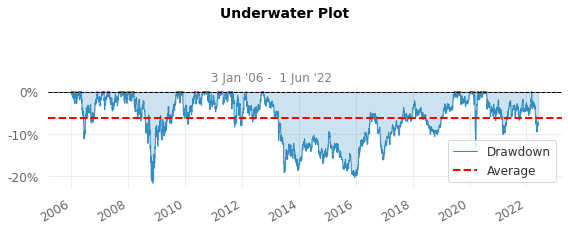

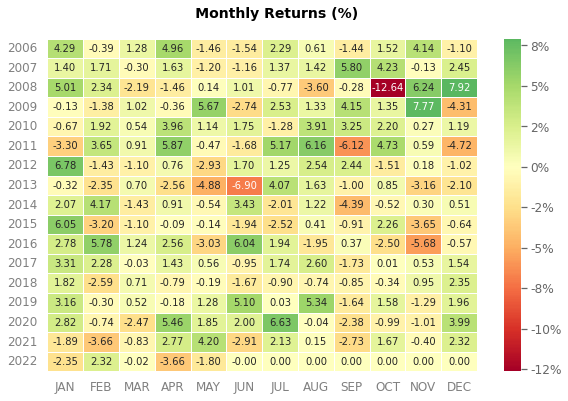

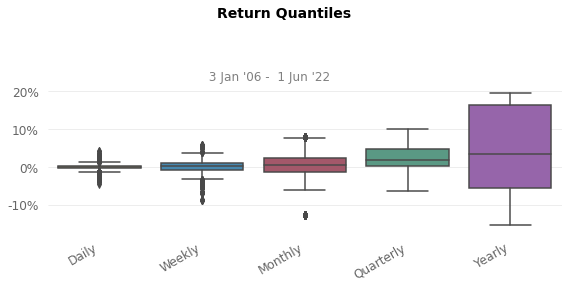

In [26]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)

In [27]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,EFA,SPY,LQD,VNQ,IEF,TLT,EEM,TIP,GLD,SHY
2006-01-03,0.0,0.056466,0.046355,0.030925,0.060895,0.090191,0.035239,0.100958,0.094802,0.434375,0.049794
2006-01-04,0.0,0.056718,0.046396,0.030807,0.061112,0.090007,0.035189,0.101484,0.09445,0.434183,0.049653
2006-01-05,0.0,0.056855,0.046772,0.031062,0.062041,0.0907,0.035409,0.102761,0.094877,0.429543,0.04998
2006-01-06,0.0,0.056772,0.046467,0.030557,0.061702,0.089248,0.034823,0.103364,0.093435,0.434377,0.049256
2006-01-09,0.0,0.056294,0.046171,0.03029,0.061673,0.088495,0.034535,0.103448,0.092711,0.43756,0.048824
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.042943,0.046531,0.040333,0.058585,0.091491,0.061938,0.038625,0.107772,0.468562,0.043219
2022-05-26,0.0,0.043359,0.047396,0.040289,0.058578,0.091324,0.061574,0.039176,0.10807,0.467063,0.043171
2022-05-27,0.0,0.043673,0.048328,0.040306,0.059862,0.091018,0.061429,0.039439,0.107896,0.465074,0.042975
2022-05-31,0.0,0.043793,0.048478,0.04036,0.059646,0.090858,0.060657,0.040344,0.10807,0.464511,0.043285


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

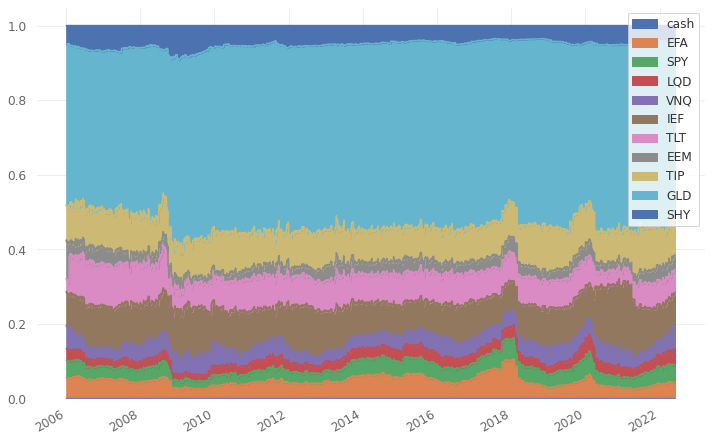

In [28]:
plt.figure(figsize=(12,8))
weight_historical_portfolio.plot.area()